In [43]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [25]:
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")


In [27]:
if (train.isnull() is True):
    print ("missing value")
else:
    print ("no missing value")
    
train.head()

no missing value


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110ce13d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1116f4210>]], dtype=object)

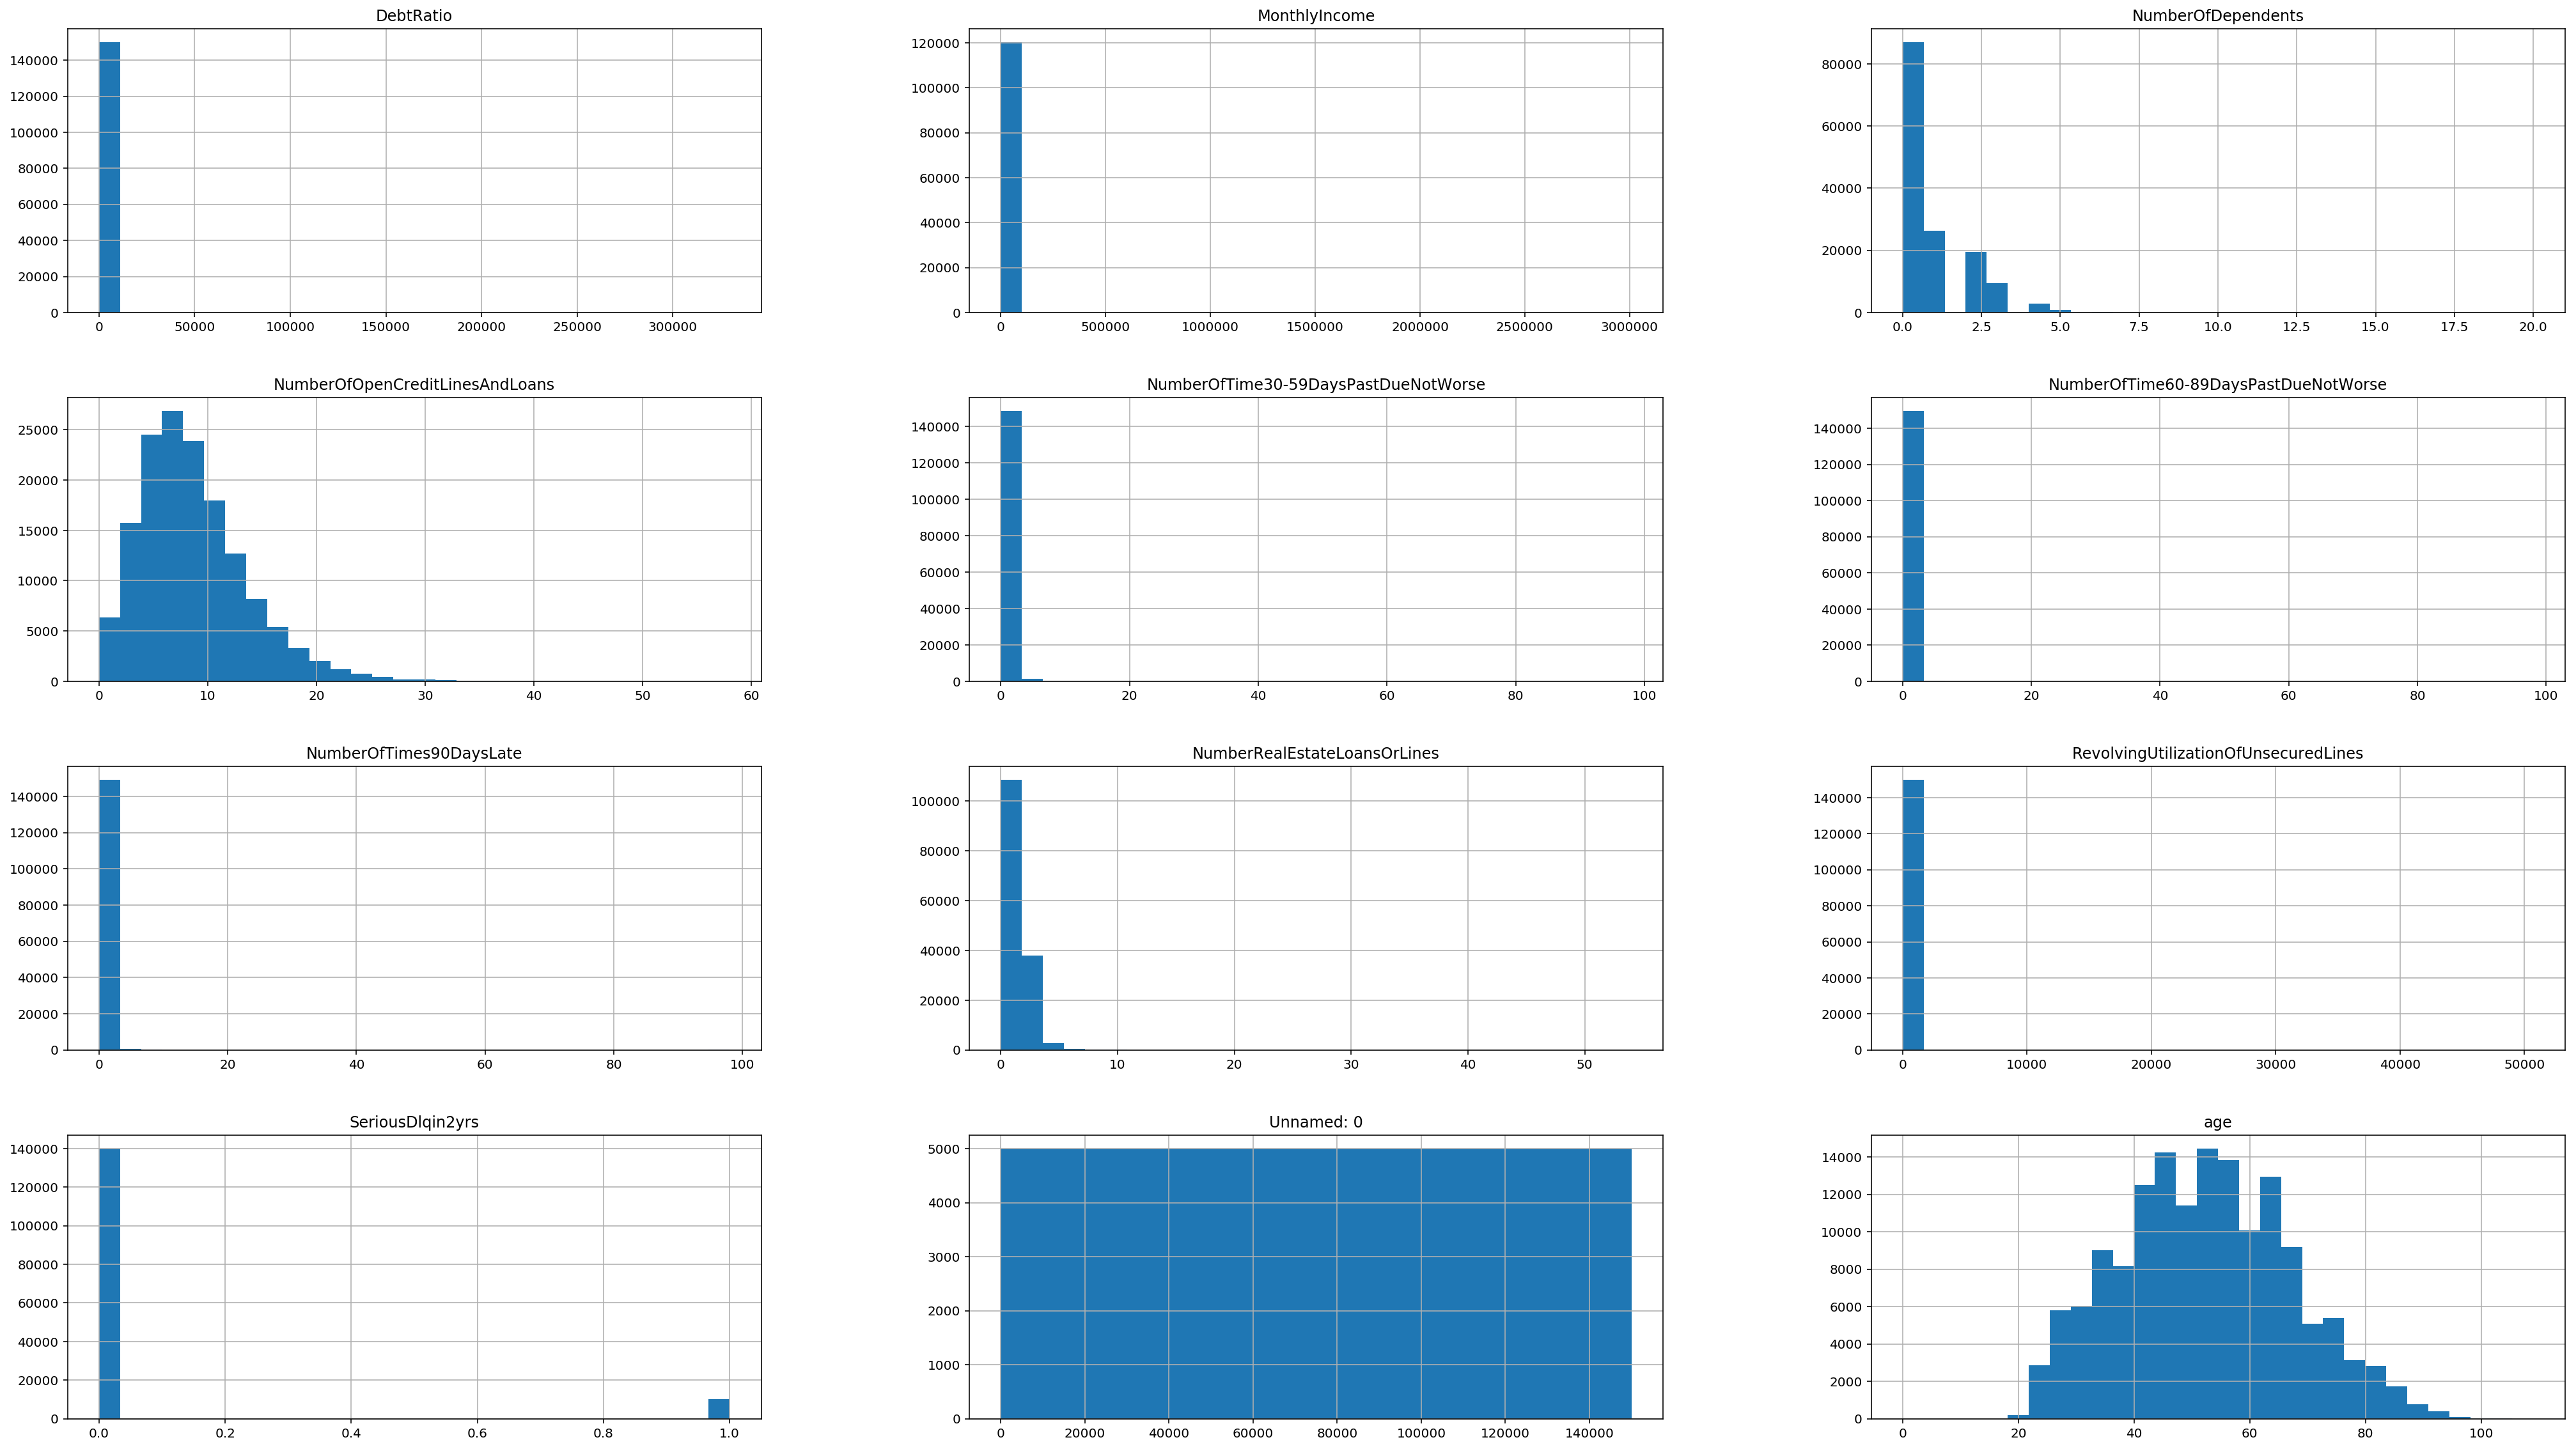

In [9]:
#Display all histograms to see data distributions for each features
matplotlib.rcParams['figure.figsize'] = (35.0, 20.0)
train.hist(bins = 30, figsize = (35.0, 20.0))

# 1.0

In [54]:
train_df = pd.read_csv('cs-training.csv')
Y = train_df['SeriousDlqin2yrs'].values
X = train_df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
test_df = pd.read_csv('cs-test.csv')
test = test_df.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }


xgb = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 4
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

random_search.fit(X, Y)

y_test = random_search.predict_proba(test)
results_df = pd.DataFrame(data={'Id':test_df['Unnamed: 0'], 'Probability':y_test[:,1]})
results_df.to_csv('xgbclassifier.csv', index=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.855025526172, total= 1.7min
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.855865871952, total= 1.7min
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, gamma=0.3, min_child_weight=1 
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, gamma=0.3, min_child_weight=1 
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.862335806575, total= 1.7min
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, 

[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 12.9min finished


Since we are classifying if someone is a high-risk individual, the XGBClassifier will be a good model that fits this problem. We ran a standard XGBClassifier with StratifiedKFold and submit the result to Kaggle, resulting a private score of 0.863163.

# 1.1

In [28]:
#Simple Model such as XGBClassifier
xgb = xgb.fit(X,Y)

#No extra on MonthlyIncome
preds_0 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with no extra MonthlyIncome is: %0.5f" %preds_0.mean())

#$1000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_1000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $1000 extra MonthlyIncome is: %0.5f" %preds_1000.mean())

#$2000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_2000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $2000 extra MonthlyIncome is: %0.5f" %preds_2000.mean())

#$3000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_3000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $3000 extra MonthlyIncome is: %0.5f" %preds_3000.mean())


Probability of delinquency with no extra MonthlyIncome is: 0.06236
Probability of delinquency with $1000 extra MonthlyIncome is: 0.06162
Probability of delinquency with $2000 extra MonthlyIncome is: 0.06102
Probability of delinquency with $3000 extra MonthlyIncome is: 0.06070


From the above result, we can see as the MonthlyIncome increases, the probability of delinquency decreases. Which make sense, higher income is a indication of financial stability, therefore lower the chance of delinquency.

# 1.2

In [5]:
train_df = pd.read_csv('cs-training.csv')
Y = train_df['SeriousDlqin2yrs'].values
X = train_df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
test_df = pd.read_csv('cs-test.csv')
test = test_df.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }


xgb_classi = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=1)
xgb_classi = xgb_classi.fit(X,Y)

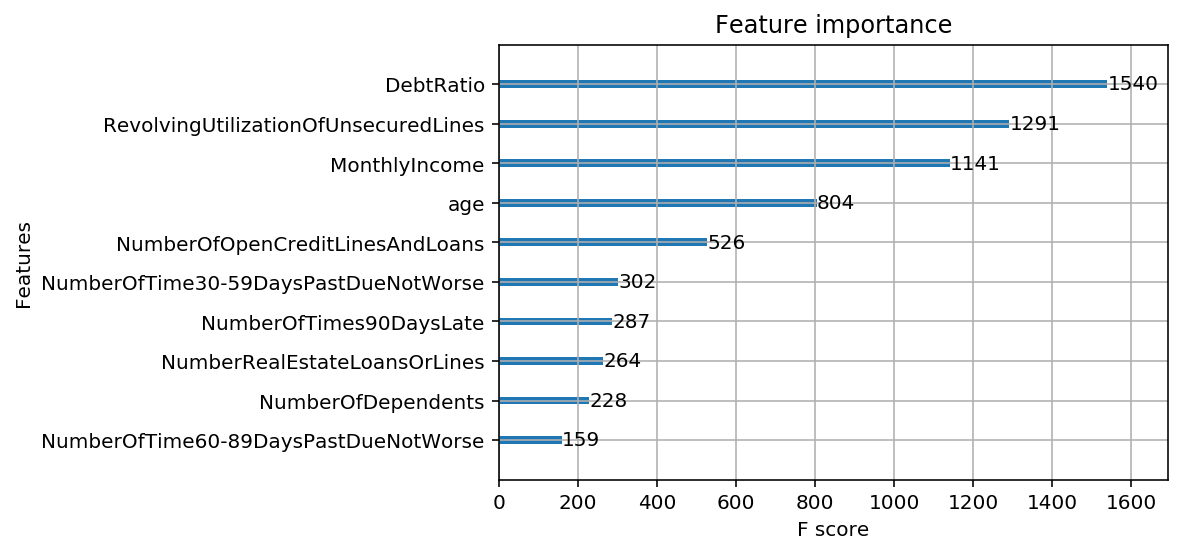

In [8]:
xgb.plot_importance(xgb_classi)

The most important variable in predicting delinquency is DebtRatio, because it has the highest F-score of 1540.
The most important pair of variables would be DebtRatio and RevolvingUtilizationOfUnsecuredLines, they have the two highest F-scores.

# 1.3

In [13]:
#Seperate Under 40 years old and 40 or older

under40 = X[X['age'] < 40]
over40 = X[X['age'] >= 40]

#Predict Probability for both age group
preds_under40 = xgb_classi.predict_proba(under40)[:,1]
print("Probability of delinquency with for people under age 40 is: %0.5f" %preds_under40.mean())
preds_over40 = xgb_classi.predict_proba(over40)[:,1]
print("Probability of delinquency with for people who are 40 or older is: %0.5f" %preds_over40.mean())

Probability of delinquency with for people under age 40 is: 0.10521
Probability of delinquency with for people who are 40 or older is: 0.05643


Base on the probability showing above, our model will predict the people who are age under 40 will have about 5% higher chance of delinquency in 2 yrs compare to those who are 40 or older. And the percentage shows that the model does not discriminate against people of age 40 or older since they have lower probability for being classified as delinquency.

# 1.4

In [21]:
#Seperate group of people based on number dependents

#First Checked unique values in column NumberOfDependents
print train_df.NumberOfDependents.unique()

#Group them based on their number of dependents
depend_0 = X[X['NumberOfDependents'] == 0]
depend_1 = X[X['NumberOfDependents'] == 1]
depend_2 = X[X['NumberOfDependents'] == 2]
depend_3 = X[X['NumberOfDependents'] == 3]
depend_4 = X[X['NumberOfDependents'] == 4]
depend_5 = X[X['NumberOfDependents'] == 5]
depend_6 = X[X['NumberOfDependents'] == 6]
depend_7 = X[X['NumberOfDependents'] == 7]
depend_8 = X[X['NumberOfDependents'] == 8]
depend_9 = X[X['NumberOfDependents'] == 9]
depend_10 = X[X['NumberOfDependents'] == 10]
depend_13 = X[X['NumberOfDependents'] == 13]
depend_20 = X[X['NumberOfDependents'] == 20]
hasDepend = X[X['NumberOfDependents'] != 0]
#Predict probability of Delinquency
preds_depend_0 = xgb_classi.predict_proba(depend_0)[:,1]
print("Probability of delinquency with for people with 0 Dependent is: %0.5f" %preds_depend_0.mean())
preds_depend_1 = xgb_classi.predict_proba(depend_1)[:,1]
print("Probability of delinquency with for people with 1 Dependent is: %0.5f" %preds_depend_1.mean())
preds_depend_2 = xgb_classi.predict_proba(depend_2)[:,1]
print("Probability of delinquency with for people with 2 Dependent is: %0.5f" %preds_depend_2.mean())
preds_depend_3 = xgb_classi.predict_proba(depend_3)[:,1]
print("Probability of delinquency with for people with 3 Dependent is: %0.5f" %preds_depend_3.mean())
preds_depend_4 = xgb_classi.predict_proba(depend_4)[:,1]
print("Probability of delinquency with for people with 4 Dependent is: %0.5f" %preds_depend_4.mean())
preds_depend_5 = xgb_classi.predict_proba(depend_5)[:,1]
print("Probability of delinquency with for people with 5 Dependent is: %0.5f" %preds_depend_5.mean())
preds_depend_6 = xgb_classi.predict_proba(depend_6)[:,1]
print("Probability of delinquency with for people with 6 Dependent is: %0.5f" %preds_depend_6.mean())
preds_depend_7 = xgb_classi.predict_proba(depend_7)[:,1]
print("Probability of delinquency with for people with 7 Dependent is: %0.5f" %preds_depend_7.mean())
preds_depend_8 = xgb_classi.predict_proba(depend_8)[:,1]
print("Probability of delinquency with for people with 8 Dependent is: %0.5f" %preds_depend_8.mean())
preds_depend_9 = xgb_classi.predict_proba(depend_9)[:,1]
print("Probability of delinquency with for people with 9 Dependent is: %0.5f" %preds_depend_9.mean())
preds_depend_10 = xgb_classi.predict_proba(depend_10)[:,1]
print("Probability of delinquency with for people with 10 Dependent is: %0.5f" %preds_depend_10.mean())
preds_depend_13 = xgb_classi.predict_proba(depend_13)[:,1]
print("Probability of delinquency with for people with 13 Dependent is: %0.5f" %preds_depend_13.mean())
preds_depend_20 = xgb_classi.predict_proba(depend_20)[:,1]
print("Probability of delinquency with for people with 20 Dependent is: %0.5f" %preds_depend_20.mean())
preds_hasDepend = xgb_classi.predict_proba(hasDepend)[:,1]
print("Probability of delinquency with for people with any number of Dependents is: %0.5f" %preds_hasDepend.mean())


[  2.   1.   0.  nan   3.   4.   5.   6.   8.   7.  20.  10.   9.  13.]
Probability of delinquency with for people with 0 Dependent is: 0.05863
Probability of delinquency with for people with 1 Dependent is: 0.07322
Probability of delinquency with for people with 2 Dependent is: 0.08180
Probability of delinquency with for people with 3 Dependent is: 0.08794
Probability of delinquency with for people with 4 Dependent is: 0.10283
Probability of delinquency with for people with 5 Dependent is: 0.09205
Probability of delinquency with for people with 6 Dependent is: 0.14287
Probability of delinquency with for people with 7 Dependent is: 0.10279
Probability of delinquency with for people with 8 Dependent is: 0.07035
Probability of delinquency with for people with 9 Dependent is: 0.01563
Probability of delinquency with for people with 10 Dependent is: 0.00863
Probability of delinquency with for people with 13 Dependent is: 0.24474
Probability of delinquency with for people with 20 Dependent i

From the above probabilities for each group with different number of dependents, we can see a trend of higher probibility of delinquency when number of dependents is higher. But some cases like 4,8,10,20 do not prove the theory of increasing trend. This is probably due to low number of Ids that have 4,8,10 or 20 dependents, so the probility is not accurate. Therefore I group all the people that have dependents together, getting probibility of 0.07814, which is around 2% higher than the people who do not have dependents. The data shows people with no dependents is less likely to be classified with delinquency with people who have dependents. Next we will calculate the p-value to express confidency.

In [85]:
t,prob= stats.ttest_ind(preds_depend_0,preds_hasDepend, equal_var=False)
print("p-value is: ")
print(prob)


p-value is: 
2.09589914066e-199


From the calculated p-value, we can see that the p-value is smaller than 0.05, which indicates strong evidence against the null hypothesis, so we reject the null hypothesis.